In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import cv2
import os

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, Dropout, Flatten, Input, BatchNormalization, MaxPool2D, Activation, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

IMG_SIZE = 224
BASE_PATH = 'dataset/chest_xray/'

train_path = os.path.join(BASE_PATH, 'train/')
test_path = os.path.join(BASE_PATH, 'test/')

In [3]:
train_normal = glob.glob(train_path + '/NORMAL/*.jpeg')
train_pneumonia = glob.glob(train_path + '/PNEUMONIA/*.jpeg')

test_normal = glob.glob(test_path + '/NORMAL/*.jpeg')
test_pneumonia = glob.glob(test_path + '/PNEUMONIA/*.jpeg')

In [4]:
X_train = [i for i in (train_normal + train_pneumonia)]
y_train = np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)])

X_test = [i for i in (test_normal + test_pneumonia)]
y_test = np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)])

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
print(f'Train : {len(X_train)}, Val : {len(X_val)}, Test : {len(X_test)}')

Train : 4185, Val : 1047, Test : 624


In [ ]:
def plot_img(img_file):
    plt.figure(figsize=(12,12))
    img = cv2.imread(img_file)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    zoom_range = 0.1,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_set = train_datagen.flow_from_dataframe(pd.DataFrame({'image': X_train, 'target' : y_train}),
                                                x_col='image',
                                                y_col='target',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                class_mode='binary',
                                                batch_size=32,
                                                seed=42)

val_set = test_datagen.flow_from_dataframe(pd.DataFrame({'image': X_val, 'target' : y_val}),
                                                y_col='target',
                                                x_col='image',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                class_mode='binary',
                                                batch_size=32,
                                                seed=42)

test_set = test_datagen.flow_from_dataframe(pd.DataFrame({'image': X_test, 'target' : y_test}),
                                                x_col='image',
                                                y_col='target',
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                class_mode='binary',
                                                batch_size=1,
                                                shuffle=False)


Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [9]:
def get_model():
    
    #Input  = [width, height, channels]
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = Conv2D(filters=16, kernel_size=3, padding='valid')(inputs) # 222, 222, 16
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D()(x) # 111, 111, 16
    x = Dropout(0.2)(x)

    # Block Two
    x = Conv2D(filters=32, kernel_size=3, padding='valid')(x) # 109, 109, 32
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D()(x) # 54, 54, 32
    x = Dropout(0.2)(x)
    
    # Block Three
    x = Conv2D(filters=64, kernel_size=3, padding='valid')(x) # 52, 52, 64
    x = Conv2D(filters=64, kernel_size=3, padding='valid')(x) # 50, 50, 64
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D()(x) # 25, 25, 64
    x = Dropout(0.4)(x)

    # Head
    x = Flatten()(x) # 40000
    x = Dense(64, activation='relu')(x) # 64
    x = Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [10]:
model = get_model()
model.compile(loss='binary_crossentropy',
             optimizer = keras.optimizers.Adam(learning_rate=3e-5), 
             metrics='binary_accuracy')

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-09-30 13:38:52.280076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-30 13:38:52.280226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [ ]:
history = model.fit(train_set,
          batch_size=32, epochs=50,
          validation_data=val_set,
          callbacks=[early_stopping, plateau])

In [12]:
def print_score(model, set):
    score = model.evaluate(set, verbose=1)
    print('Val loss:', score[0])
    print('Val accuracy:', score[1])

In [15]:
print_score(model, val_set)
print_score(model, test_set)

2022-09-30 13:41:30.241933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 6s 180ms/step - loss: 0.3122 - binary_accuracy: 0.8968
Val loss: 0.3121780455112457
Val accuracy: 0.8968481421470642
624/624 [==============================] - 4s 7ms/step - loss: 0.3748 - binary_accuracy: 0.8494
Val loss: 0.37475207448005676
Val accuracy: 0.8493589758872986


In [ ]:
model.save('model/my_model.h5')

In [16]:
resnet_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

resnet_model.trainable = False

def get_pretrained():
    
    #Input = [width, height, channels]
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = resnet_model(inputs)

    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[inputs], outputs=output)
    
    return model

234545216/234545216 [==============================] - 6s 0us/step


In [17]:
model_pretrained = get_pretrained()

resnet_model.trainable = True

for layer in resnet_model.layers[:-13]:
    layer.trainable = False

model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                           

In [ ]:
history = model_pretrained.fit(train_set,
          batch_size=32, epochs=50,
          validation_data=val_set,
          callbacks=[early_stopping, plateau])

In [19]:
model_pretrained = tf.keras.models.load_model('model/imagnet_pretrain_model.h5')

In [20]:
print_score(model_pretrained, val_set)
print_score(model_pretrained, test_set)

2022-09-30 13:43:00.518425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 15s 355ms/step - loss: 0.0714 - binary_accuracy: 0.9771
Val loss: 0.07136379927396774
Val accuracy: 0.9770773649215698
624/624 [==============================] - 26s 39ms/step - loss: 0.2819 - binary_accuracy: 0.8958
Val loss: 0.28193584084510803
Val accuracy: 0.8958333730697632


In [21]:
pred_vals = model_pretrained.predict(test_set)
cm = confusion_matrix(test_set.classes, pred_vals > 0.5)
cm

2022-09-30 13:47:31.532993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


624/624 [==============================] - 24s 35ms/step


array([[172,  62],
       [  3, 387]])

<Figure size 640x480 with 0 Axes>

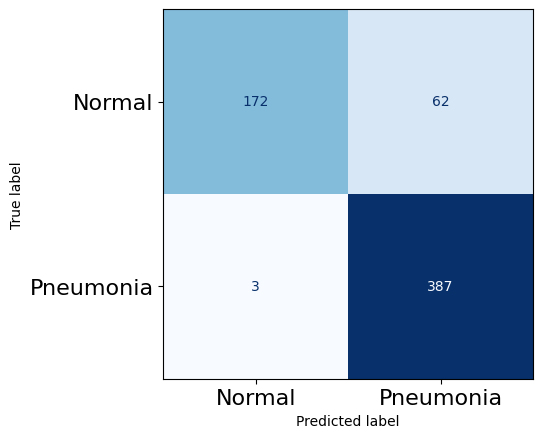

In [22]:
plt.figure()
disp = ConfusionMatrixDisplay(cm)
disp.plot(colorbar=False, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [23]:
pd.DataFrame(classification_report(test_set.classes, pred_vals > 0.5, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.982857,0.861915,0.895833,0.922386,0.907269
recall,0.735043,0.992308,0.895833,0.863675,0.895833
f1-score,0.841076,0.922527,0.895833,0.881801,0.891983
support,234.000000,390.000000,0.895833,624.000000,624.000000


In [ ]:
model_pretrained.save('model/imagnet_pretrain_model.h5')